# Biais froid sur le Plateau Tibétain et projections climatiques (CMIP6)

[PAX7STAF - Variabilité Climatique et Environnementale](https://chamilo.univ-grenoble-alpes.fr/courses/PAX7STAF/index.php?id_session=0)

## Import des modules / packages
- [intake](https://intake-esm.readthedocs.io/en/latest/) : pour accéder aux données 
- [xarray](http://xarray.pydata.org/en/stable/) : pour manipuler les données
- [proplot](https://proplot.readthedocs.io/en/latest/) : pour faire des plots
- [xesmf](https://xesmf.readthedocs.io/en/latest/) : pour faire des regrid
- [dask](https://dask.org/) pour faire de la parallélisation (mais vous ne devriez pas pas tellement vous préocuper de ce packages)

In [1]:
import intake 
import xarray as xr
import proplot as plot
import xesmf as xe

## Récupération des données CMIP6 via Intake ([tuto](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html))
Cela est possible grâce au projet [Pangeo](https://pangeo.io/) et aux [Google Cloud](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets) ! (encore assez expérimental)

Autrement il faut télécharger les données sur https://esgf-node.llnl.gov/search/cmip6/ (base de donnée officielle à l'échelle internationnale, mais cela est beaucoup plus fastidieux)

In [3]:
# Visualise toutes les données disponibles (on ne télécharge rien ici pour le moment)

url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,15
institution_id,34
source_id,77
experiment_id,105
member_id,207
table_id,29
variable_id,388
grid_label,10
zstore,287644
dcpp_init_year,60


In [4]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


In [5]:
# Visualise toutes les expériences, modèles et table ici par exemple

import pprint

uni_dict = col.unique(["source_id", "experiment_id", "table_id"])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 105,
                   'values': ['1pctCO2', '1pctCO2-bgc', '1pctCO2-rad',
                              'abrupt-0p5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2',
                              'abrupt-solm4p', 'abrupt-solp4p', 'amip',
                              'amip-4xCO2', 'amip-future4K', 'amip-hist',
                              'amip-lwoff', 'amip-m4K', 'amip-p4K',
                              'amip-p4K-lwoff', 'aqua-4xCO2', 'aqua-control',
                              'aqua-control-lwoff', 'aqua-p4K',
                              'aqua-p4K-lwoff', 'control-1950', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-amv-ExTrop-neg',
                              'dcppC-amv-ExTrop-pos', 'dcppC-amv-Trop-neg',
                              'dcppC-amv-Trop-pos', 'dcppC-amv-neg',
                              'dcppC-amv-pos', 'dcppC-atl-control',
                              'dcppC-atl-pacemaker', 'dcppC-hindcast-noAgung',
                 

### Selection des données souhaitées
Ici je mets donc le modèle `IPSL-CM6A-LR` pour la variable `tas` (température de l'air proche de la surface - de manière générale à 2 mètres au dessus du sol), en mensuel (soit la table Atmosphérique monthly `Amon`). Pour commencer vous pouvez regarder le premier membre `r1i1p1f1` puis ensuite essayer d'estimer la variabilité interne du modèle et estimer une erreur sur vos résultats de projection.

In [6]:
cat = col.search(
    experiment_id=["historical"],
#     experiment_id=["historical", "ssp585"],
    table_id="Amon",
    variable_id="tas",
    source_id="IPSL-CM6A-LR",
#     member_id="r1i1p1f1"
)

cat

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,32
table_id,1
variable_id,1
grid_label,1
zstore,32
dcpp_init_year,0


In [7]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
1,CMIP,IPSL,IPSL-CM6A-LR,historical,r11i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
2,CMIP,IPSL,IPSL-CM6A-LR,historical,r12i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
3,CMIP,IPSL,IPSL-CM6A-LR,historical,r13i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
4,CMIP,IPSL,IPSL-CM6A-LR,historical,r14i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803


In [9]:
cat.keys()

['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']

In [10]:
# Cette cellule permet de récupérer les données sous forme de dataset xarray/dask mais rien n'est encore loadé sur votre PC
# Cela peut prendre quelques minutes le temps d'indexer toutes les données

data_source = cat[cat.keys()[0]]
ds = data_source(
    zarr_kwargs={"consolidated": True, "decode_times": True}
).to_dask()
ds

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 143, lon: 144, member_id: 32, time: 1980)
Coordinates:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
    height       float64 ...
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
  * member_id    (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
Dimensions without coordinates: axis_nbounds
Data variables:
    tas          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 143, 144), meta=np.ndarray>
Attributes:
    contact:                 ipsl-cmip6@listes.ipsl.fr
    EXPID:                   historical
    intake_esm_varname:      tas
    realm:                   atmos
    table_id:                Amon
    experiment:              all-forcing simulation of the recent past
    Conventions:             CF-1.7 CMIP-6.2
    NCO:                     "4.6.0"
    branch_time_in_child:    0.0
    external_variables:      areacella
    grid:                    LMDZ grid
    parent_mip_era:          CMIP6
    history:                 Mon Sep  3 17:43:49 2018: ncatted -O -a parent_v...
    sub_experiment:          none
    initialization_index:    1
    data_specs_version:      01.00.21
    parent_activity_id:      CMIP
    status:                  2019-10-25;created;by nhn2@columbia.edu
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_variant_label:    r1i1p1f1
    experiment_id:           historical
    CMIP6_CV_version:        cv=6.2.3.5-2-g63b123e
    source_type:             AOGCM BGC
    physics_index:           1
    description:             CMIP6 historical
    parent_source_id:        IPSL-CM6A-LR
    tracking_id:             hdl:21.14100/73b9d5f7-02af-424d-b209-bd6e9b470c1...
    nominal_resolution:      250 km
    variable_id:             tas
    product:                 model-output
    variant_info:            Restart from another point in piControl.. Inform...
    source:                  IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 14...
    frequency:               mon
    institution_id:          IPSL
    sub_experiment_id:       none
    title:                   IPSL-CM6A-LR model output prepared for CMIP6 / C...
    parent_experiment_id:    piControl
    activity_id:             CMIP
    forcing_index:           1
    grid_label:              gr
    mip_era:                 CMIP6
    license:                 CMIP6 model data produced by IPSL is licensed un...
    source_id:               IPSL-CM6A-LR
    institution:             Institut Pierre Simon Laplace, Paris 75252, France
    branch_method:           standard
    intake_esm_dataset_key:  CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr

### Vérification de la taille des données

In [15]:
# Vérifier la taille des données (voir fonction ci-dessous pour avoir quelque chose de lisible)
ds.nbytes

5218886308

In [13]:
# https://stackoverflow.com/a/14822210/6344670
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [16]:
convert_size(ds.nbytes)

'4.86 GB'

En fonction de la taille il peut être judicieux de sélectionner les données que vous avez besoin avant de faire des opérations afin de ne surcharger la mémoire de votre PC ! (surtout avec tous les membres)

### Chargement des données utiles
Seulement sur la zone HMA par exemple pour réduire grandement la taille des données et également sur le temps

In [17]:
lonlim = slice(50,120)
latlim = slice(0,60)

In [22]:
tas = ds.tas.sel(lon=lonlim, lat=latlim, time=slice('1950','2014'))
tas

,Array,Chunk
Bytes,138.98 MB,3.34 MB
Shape,"(32, 780, 48, 29)","(1, 600, 48, 29)"
Count,482 Tasks,64 Chunks
Type,float32,numpy.ndarray


In [23]:
convert_size(tas.nbytes)

'132.54 MB'

In [24]:
# Chargement des données (peu être un peu long mais comme ça les calculs seront ensuite plus rapide !)
# http://xarray.pydata.org/en/stable/dask.html#optimization-tips
tas.load()

<xarray.DataArray 'tas' (member_id: 32, time: 780, lat: 48, lon: 29)>
array([[[[298.2208 , 298.51138, 298.81454, ..., 295.65952, 298.95953,
          298.5877 ],
         [297.97238, 298.31577, 298.56506, ..., 293.64233, 296.62265,
          298.27945],
         [297.63016, 298.13223, 298.4    , ..., 293.82925, 297.14944,
          299.21765],
         ...,
         [257.39725, 257.7527 , 257.85394, ..., 241.71571, 241.91318,
          243.85373],
         [255.8759 , 256.11417, 256.40042, ..., 241.96811, 245.60889,
          245.47333],
         [255.15437, 254.99193, 255.02   , ..., 245.07983, 247.35251,
          244.82822]],

        [[298.44553, 298.57602, 299.00958, ..., 295.96436, 299.55432,
          298.76382],
         [298.18005, 298.44394, 298.86554, ..., 293.8631 , 297.42975,
          298.41672],
         [297.75238, 298.1968 , 298.54865, ..., 294.1237 , 297.63544,
          299.4067 ],
...
         [264.91772, 264.91818, 265.4053 , ..., 254.3767 , 251.6674 ,
          252.44788],
         [264.21762, 264.17557, 264.42267, ..., 254.76811, 255.60193,
          255.28775],
         [263.49792, 263.77036, 263.45206, ..., 254.39026, 257.3185 ,
          257.5133 ]],

        [[299.65305, 300.07703, 300.53116, ..., 297.47488, 301.01666,
          300.29684],
         [299.2449 , 299.6947 , 300.17307, ..., 294.93185, 298.45248,
          299.98203],
         [298.99213, 299.42722, 299.9134 , ..., 295.14752, 299.36163,
          301.21405],
         ...,
         [260.98944, 260.78232, 259.6533 , ..., 236.46397, 235.92227,
          237.5837 ],
         [259.8277 , 258.96323, 257.7569 , ..., 236.45401, 239.41414,
          238.85115],
         [258.60574, 257.78214, 256.44247, ..., 238.75433, 241.74393,
          239.91321]]]], dtype=float32)
Coordinates:
    height     float64 2.0
  * lat        (lat) float32 0.0 1.2676057 2.5352113 ... 58.30986 59.577465
  * lon        (lon) float32 50.0 52.5 55.0 57.5 ... 112.5 115.0 117.5 120.0
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         Near-Surface Air Temperature
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Near-Surface Air Temperature
    online_operation:    average
    standard_name:       air_temperature
    units:               K

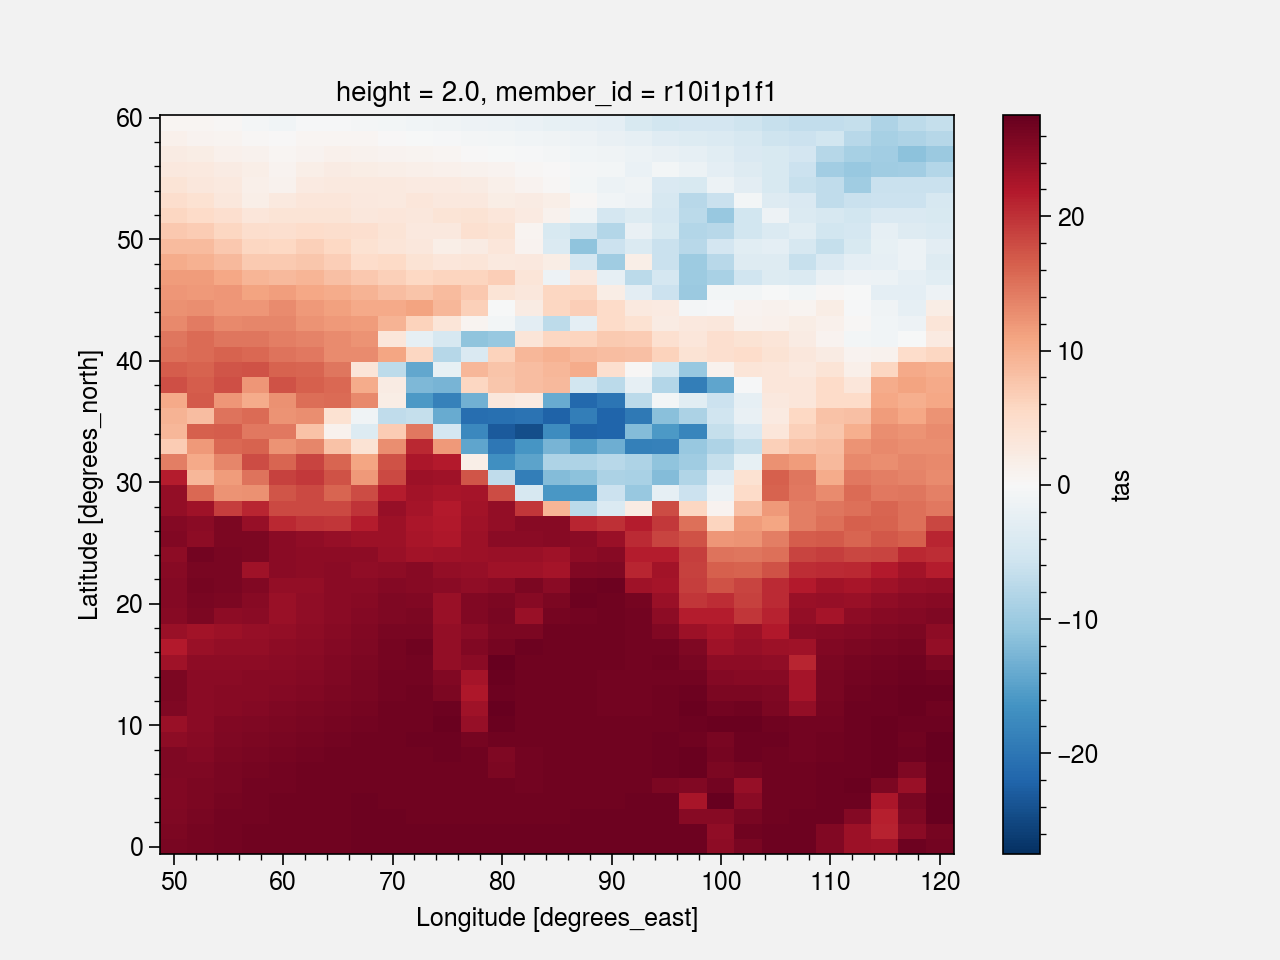

In [30]:
# Visualisation rapide de la climatologie d'un membre
clim = tas.isel(member_id=0).mean('time') - 273.15
clim.plot()

In [42]:
clim.min().values, clim.max().values

(array(-24.487091, dtype=float32), array(27.529297, dtype=float32))

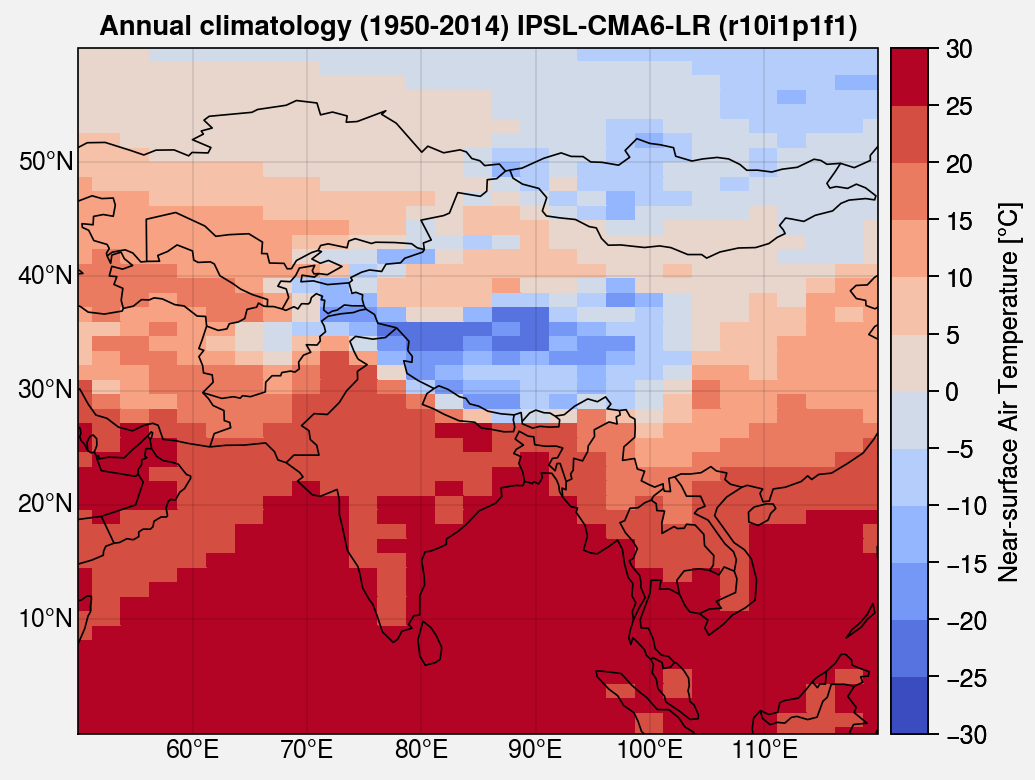

In [71]:
# Visualisation avec Proplot (vous pouvez aussi directement utiliser Cartopy/matplotlib)
# https://proplot.readthedocs.io/en/latest/projections.html

fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-30,30,5)

m = axs[0].pcolormesh(clim, cmap='CoolWarm', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Annual climatology (1950-2014) IPSL-CMA6-LR ('+str(clim.member_id.values)+')'
)

## Récupération des données d'observation

https://crudata.uea.ac.uk/cru/data/hrg/: CRU TS v. 4.04

Il faut vous créer un compte, ici je vous ai mis un jeu de données de base pour commencer (que j'ai finalement retiré car trop gros mais vous devriez pouvoir le télécharger assez facilement sinon je vous le passerai d'une autre manière), mais vous pouvez ensuite regarder d'autres variables et en particulier le nombre de stations par exemple pour voir dans quelle mesures ces données sont fiables sur cette zone... (faire aussi de la bibliographie, quelle sorte de données c'est : satelittle, station, etc. ?)

Si vous voulez ensuite analyser la couverture de neige ou les précipitations, n'hésitez pas à revenir vers moi pour que je vous indiques d'autres jeux de données (plus compliqué pour les autres variables mais c'est intéressant si vous voulez comparer !)

In [60]:
ds_obs = xr.open_dataset('data/cru_ts4.04.1901.2019.tmp.dat.nc')
ds_obs

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1428)
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2019-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.04 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2004151855. Data generated from:tmp.2004011744.dtb
    history:      Wed 15 Apr 2020 19:58:33 BST : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [62]:
clim_obs = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).mean('time')
clim_obs

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'tmp' (lat: 120, lon: 140)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
        25.135262 ],
       [       nan,        nan,        nan, ..., 25.937695 ,        nan,
               nan],
       [       nan,        nan,        nan, ..., 27.0727   ,        nan,
               nan],
       ...,
       [ 2.63923  ,  2.559743 ,  2.4567938, ..., -6.8505096, -7.014485 ,
        -6.0183325],
       [ 2.187309 ,  2.1924367,  2.182822 , ..., -6.6196165, -6.2071795,
        -6.222696 ],
       [ 1.8861524,  1.850001 ,  1.9001281, ..., -6.495249 , -6.4252586,
        -6.512051 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 50.25 50.75 51.25 51.75 ... 118.75 119.25 119.75
  * lat      (lat) float32 0.25 0.75 1.25 1.75 2.25 ... 58.25 58.75 59.25 59.75

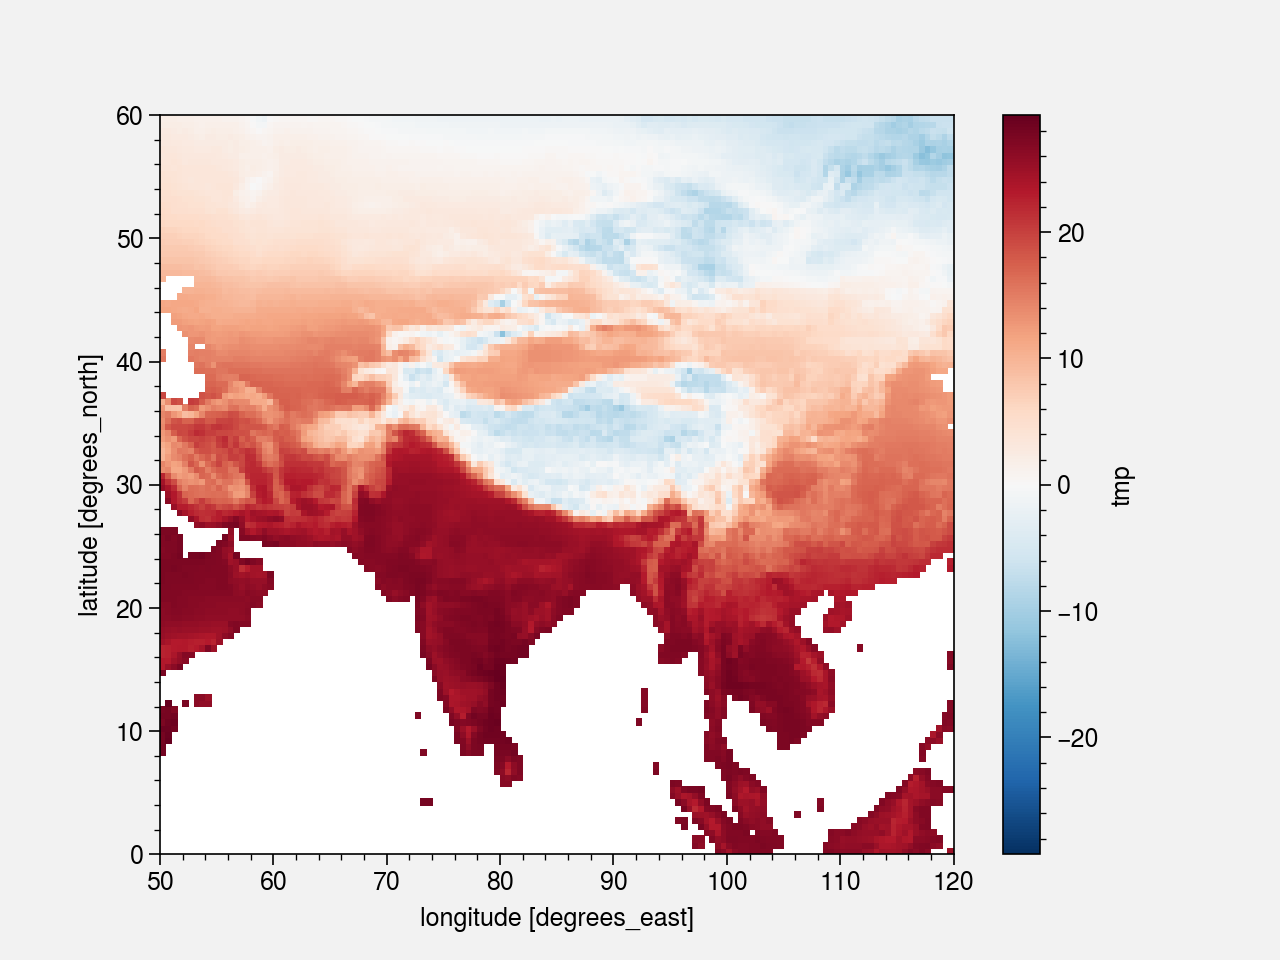

In [63]:
clim_obs.plot()

## Faire un regrid des obs vers le modèle avec [xESMF](https://xesmf.readthedocs.io/en/latest/)
(regrid toujours vers la résolution la moins bonne en général)

Il est également possible de faire directement une interpolation avec xarray (http://xarray.pydata.org/en/stable/interpolation.html), cependant cela ne prend pas en compte la sphéricité de la Terre, du coup c'est mieux xESMF mais si vous n'arrivez pas à le faire fonctionner c'est une alternative (ou également CDO)

In [66]:
# Create the regridder
# Use periodic=True if the data are global
regridder = xe.Regridder(clim_obs, clim, method='bilinear', reuse_weights=True, periodic=False)
clim_obs_regrid = regridder(clim_obs)
clim_obs_regrid

Reuse existing file: bilinear_120x140_48x29.nc


<xarray.DataArray 'tmp' (lat: 48, lon: 29)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,          nan,          nan, ...,  23.88499227,
         26.56655458,   0.        ],
       [  0.        ,          nan,          nan, ...,  22.81418685,
         27.02194943,   0.        ],
       ...,
       [  0.        ,   2.94535005,   2.81480653, ...,  -8.90195198,
        -11.73743118,   0.        ],
       [  0.        ,   2.44513318,   2.2387016 , ...,  -8.73682229,
         -9.15414552,   0.        ],
       [  0.        ,   1.8237865 ,   1.59958366, ...,  -9.17068591,
         -7.76056052,   0.        ]])
Coordinates:
  * lon      (lon) float32 50.0 52.5 55.0 57.5 60.0 ... 112.5 115.0 117.5 120.0
  * lat      (lat) float32 0.0 1.2676057 2.5352113 ... 58.30986 59.577465
Attributes:
    regrid_method:  bilinear

In [67]:
clim_obs_regrid

<xarray.DataArray 'tmp' (lat: 48, lon: 29)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,          nan,          nan, ...,  23.88499227,
         26.56655458,   0.        ],
       [  0.        ,          nan,          nan, ...,  22.81418685,
         27.02194943,   0.        ],
       ...,
       [  0.        ,   2.94535005,   2.81480653, ...,  -8.90195198,
        -11.73743118,   0.        ],
       [  0.        ,   2.44513318,   2.2387016 , ...,  -8.73682229,
         -9.15414552,   0.        ],
       [  0.        ,   1.8237865 ,   1.59958366, ...,  -9.17068591,
         -7.76056052,   0.        ]])
Coordinates:
  * lon      (lon) float32 50.0 52.5 55.0 57.5 60.0 ... 112.5 115.0 117.5 120.0
  * lat      (lat) float32 0.0 1.2676057 2.5352113 ... 58.30986 59.577465
Attributes:
    regrid_method:  bilinear

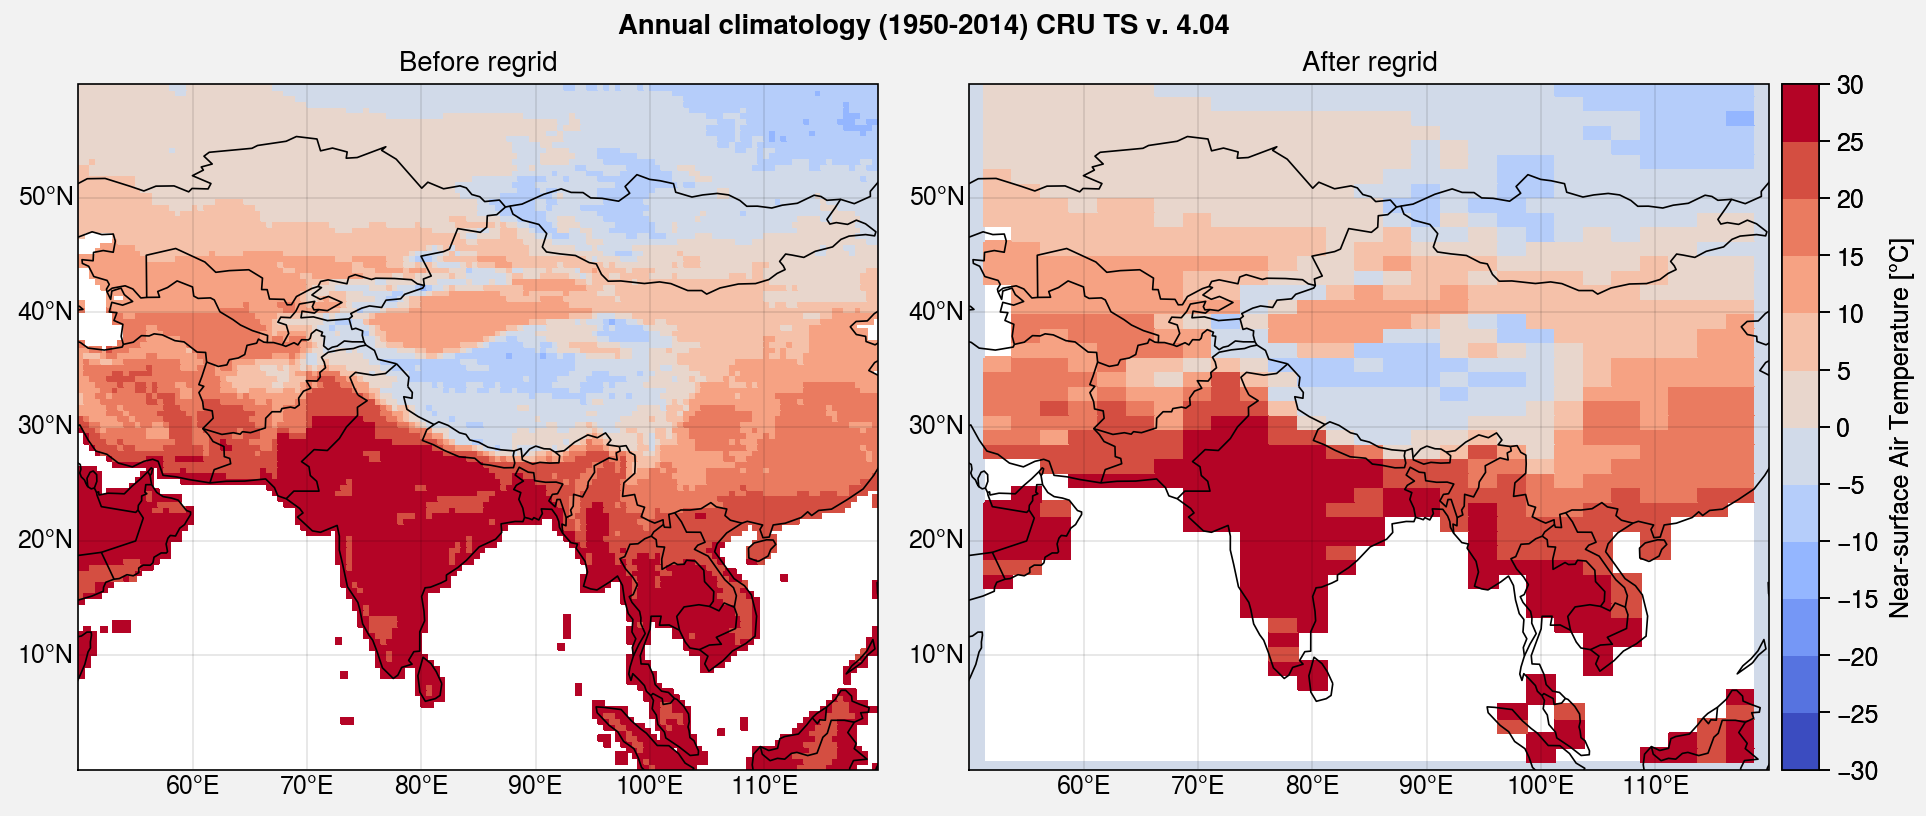

In [75]:
fig, axs = plot.subplots(ncols=2, proj='cyl', axwidth=4)

levels = plot.arange(-30,30,5)
cmap = 'CoolWarm'

axs[0].pcolormesh(clim_obs, cmap=cmap, levels=levels)
axs[0].format(title='Before regrid')

m = axs[1].pcolormesh(clim_obs_regrid, cmap=cmap, levels=levels)
axs[1].format(title='After regrid')
axs[1].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Annual climatology (1950-2014) CRU TS v. 4.04'
)

## Calcul du biais
Le regrid crée quelque effets de bords du coup vous pourrez virer les bords pour les plots suivants

In [76]:
biais = clim - clim_obs_regrid

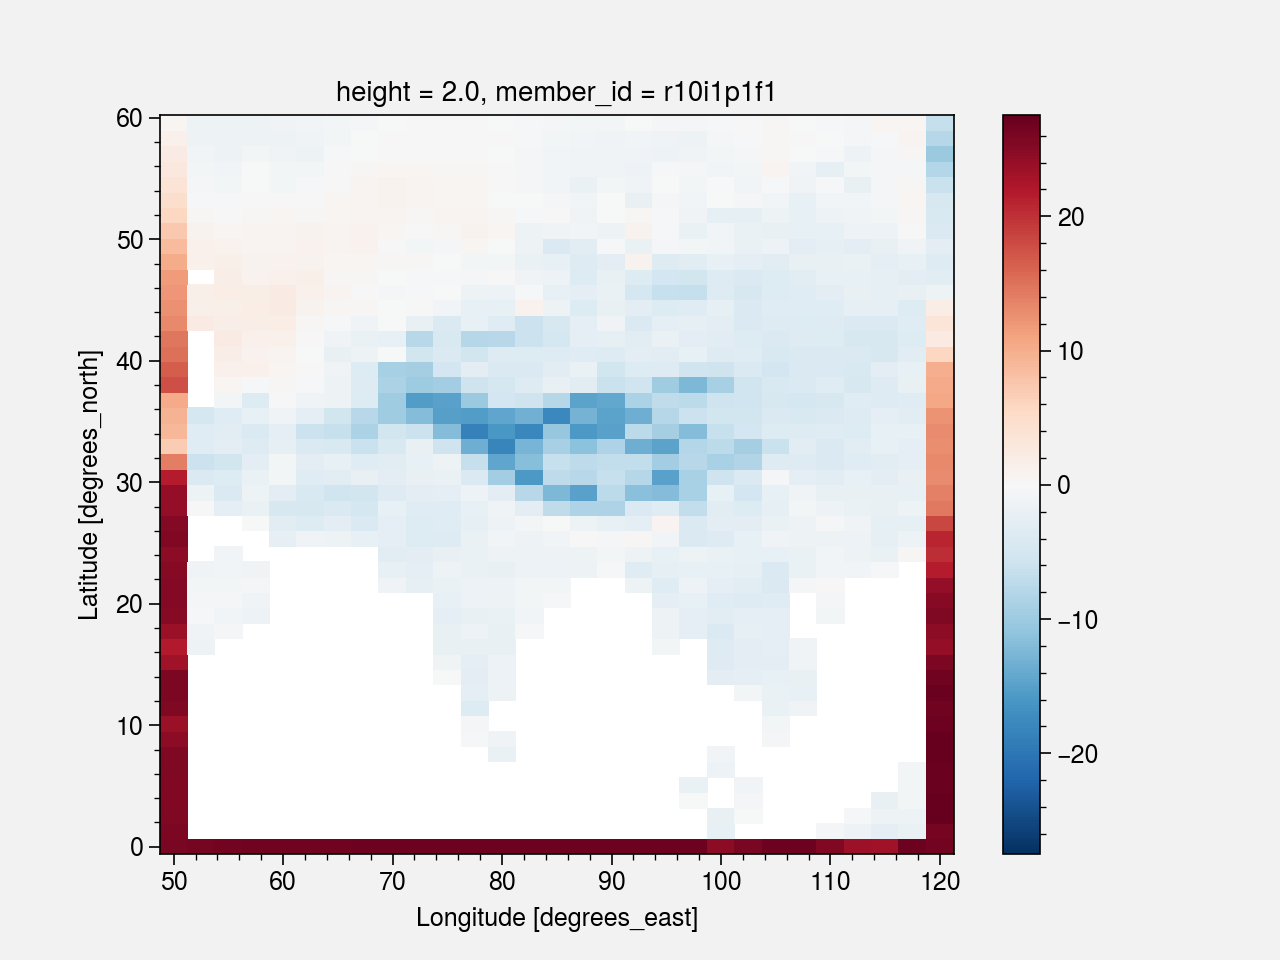

In [78]:
biais.plot()

In [80]:
biais.min()

<xarray.DataArray ()>
array(-18.54231148)
Coordinates:
    height     float64 2.0
    member_id  <U9 'r10i1p1f1'

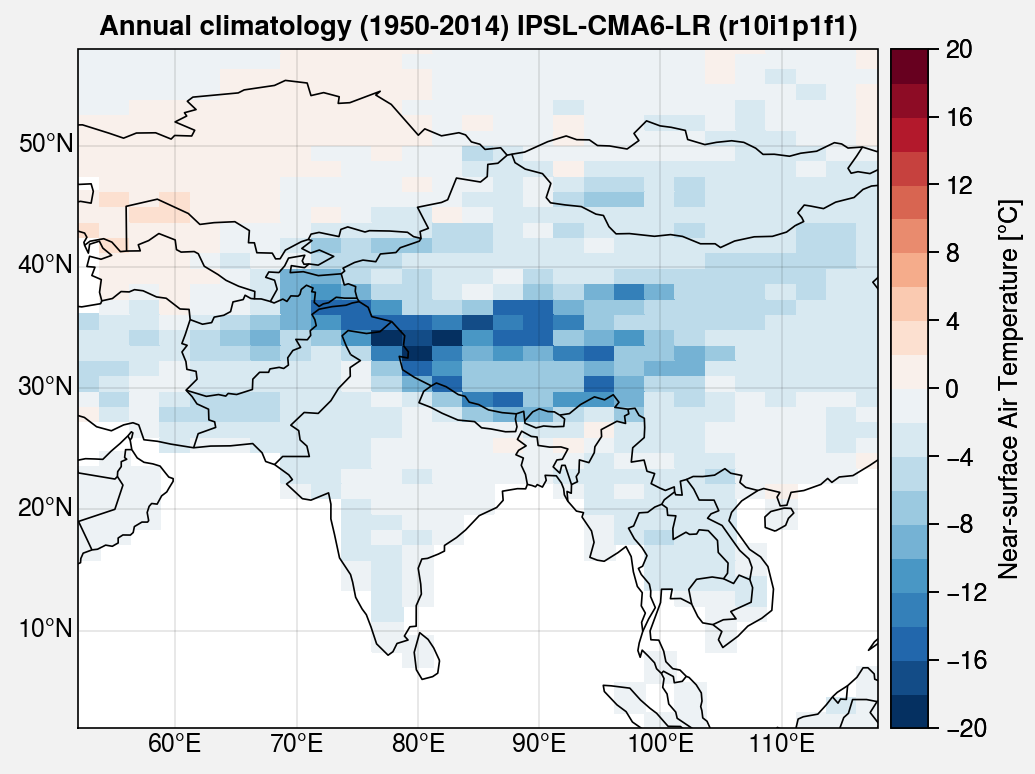

In [88]:
fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-20,20,2)

m = axs[0].pcolormesh(biais, cmap='BuRd', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start+2, lonlim.stop-2), latlim=(latlim.start+2, latlim.stop-2), # pour virer les bords +-2, vous pouvez le faire direct sur les données
    suptitle='Annual climatology (1950-2014) IPSL-CMA6-LR ('+str(clim.member_id.values)+')'
)

## Topographie GMTED2010 et suite du travail
Essayez de télécharger le fichier de topographie `GMTED2010_15n240_1000deg.nc` (http://www.temis.nl/data/gmted2010/) et de faire un regrid également vers la grille modèle (ce n'est pas parfait mais bon c'est histoire d'avoir une zone approximative du plateau tibétain). Vous pourrez ensuite sélectionner seulement la zone par exemple où l'altitude est supérieure à 2500 m :
```python
clim.where(topo > 2500)
```
Vous pourrez comme ça ensuite calculer un biais moyen sur cette zone (pensez au fait que la Terre est ronde pour faire les moyennes spatiales). L'idée serait ensuite d'utiliser cette zone pour faire des séries temporelles (du coup à appliquer avant de faire la climatologie, vous pouvez faire le regrid plus tôt dans le code). N'hésitez pas à prendre la période que vous voulez (je n'ai fait qu'un exemple ici pour vous familiariser avec le code). Vous pouvez comparer les périodes pré-industrielle à aujourd'hui et/ou aux scénarios futur !

Exemple de plot de projection :

![](img/projection_AR5.png)

Les anomalies sont calculées ici par rapport à la climatologie 1995-2014 pour un membre de chaque modèles. De votre côté pour simplifier vous pouvez vous limiter au seul modèle de l'IPSL mais par contre faire quelque chose de similaire avec tous les 32 membres.

Si vous voulez également faire des calculs de tendances je vous conseille de regarder la fonction `linregress` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). N'hésitez pas à faire toutes sortes d'analyses que vous avez déjà appris (cycle annuel, refaire vos analyses en saisonnier pour voir si le biais est plus important en hiver ou été), etc.)

# A vous de jouer !